In [2]:
#Author: Eren Ali Aslangiray

import pywt
import librosa
from librosa import display
import time
import os
import pandas as pd
import joblib
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
sr=22050

Using TensorFlow backend.


### Author's Notes:

At part 1, I tried to build various models and with using different feature extraction methods to find best data extraction and model to use it on mass model building step. So part 1 is mini version and the exeperimental area of the whole work.

# ----------------------DATA PREPARING----------------------

# 1- RAVDESS DATABASE

## 1.1- Data Extraction

In [24]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24'
lst = []

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file) == "/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/.DS_Store":
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = int(file[7:8]) - 1
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [26]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [33]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 1.2- Data Load

In [315]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/y.joblib')
y = np.asanyarray(y)

## 1.3- MEAN MFCCs KERAS MODEL (With 8 Emotion Label)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [80]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
__________

In [82]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model.h5')
loaded_model.summary()
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

## 1.4- MEAN MFCCs KERAS MODEL (With reduced labels. Labels = 4)

In [180]:
#Dont forget to load data from 1.2
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
# 0 = neutral, 1 = angry, 2 = happy, 3 = sad
#calm became neutral. fearful, disgust, surprised will be removed. 
i = 0
for item in y:
    if item == 1:
        y[i]=0
    i = i+1
i = 0
for item in y:
    if item==4:
        y[i]=1
    i = i +1

lista = list(X)
listb = list(y)
dellist = [5,6,7]

for i in range (len(listb)-1,-1,-1):
    if listb[i] in dellist:
        lista.pop(i)
        listb.pop(i)

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(lista), np.asarray(listb), test_size=0.33, random_state=42)

In [183]:
#DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

In [184]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.54      0.66      0.59        91
           1       0.49      0.52      0.50        67
           2       0.48      0.41      0.44        61
           3       0.39      0.30      0.34        67

   micro avg       0.49      0.49      0.49       286
   macro avg       0.47      0.47      0.47       286
weighted avg       0.48      0.49      0.48       286



In [2]:
#Now its time for keras :)

import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [68]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

model = Sequential()
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [69]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

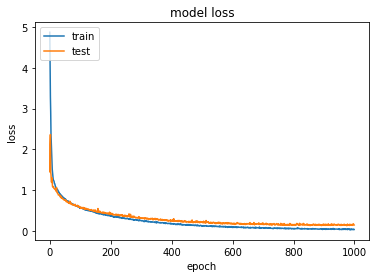

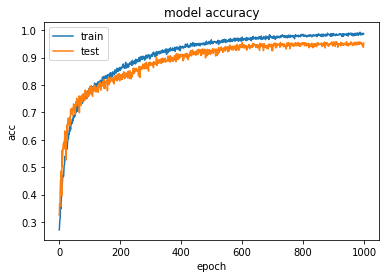

In [71]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       378
           1       0.96      0.92      0.94       238
           2       0.95      0.94      0.94       267
           3       0.94      0.96      0.95       243

   micro avg       0.95      0.95      0.95      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.95      0.95      0.95      1126



In [74]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)
# 0 = neutral, 1 = angry, 2 = happy, 3 = sad

[[371   0   3   4]
 [  5 219  10   4]
 [  4   7 250   6]
 [  8   2   0 233]]


In [75]:
model_name = 'Emotion_Voice_Detection_Model_Reduced_Labels.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Emotion_Voice_Detection_Model_Reduced_Labels.h5 


In [15]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model_Reduced_Labels.h5')
#loss, acc = loaded_model.evaluate(x_testcnn, y_test)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))
X, sample_rate = librosa.load("/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/1/JE/a04.wav")
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
asd= []
asd.append(mfccs)
asd = np.expand_dims(asd,axis=2)
asd.shape
loaded_model.pred(asd)

array([[7.1461642e-01, 4.3570972e-04, 2.8092381e-01, 2.8527708e-04,
        3.1280790e-05, 3.5926604e-04, 2.8526308e-03, 4.9557863e-04]],
      dtype=float32)

## 1.5- MEAN DB AMPLITUDE MODEL AND .T VERSION (Soruce Data - LESS Data) - WITH REDUCED LABELS.

In [259]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/X_wave.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/y_wave.joblib')

In [181]:
X_db = []
for item in X:
    S = librosa.feature.melspectrogram(y=item, sr=sr)
    k = np.mean(librosa.amplitude_to_db(S, ref=np.max).T,axis=0)
    X_db.append(k)

In [182]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X_db), y, test_size=0.33, random_state=42)

In [185]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

model = Sequential()
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(128,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [186]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

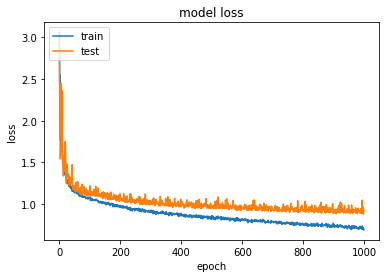

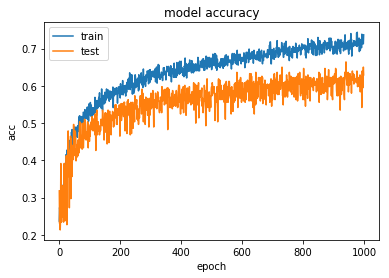

In [197]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [198]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.74      0.71        91
           1       0.63      0.93      0.75        67
           2       0.57      0.44      0.50        61
           3       0.57      0.36      0.44        67

   micro avg       0.63      0.63      0.63       286
   macro avg       0.61      0.62      0.60       286
weighted avg       0.62      0.63      0.61       286



In [200]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)
# 0 = neutral, 1 = angry, 2 = happy, 3 = sad

[[67  7  6 11]
 [ 2 62  2  1]
 [ 7 21 27  6]
 [22  9 12 24]]


# 2- SAVEE DATABASE

## 2.1- Data Extraction

In [14]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/1'
lst = []
numlist = ["0","1","2","3","4","5","6","7","8","9"]

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = file[0:2]
        if file[1] in numlist:
            file = file[0]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [16]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [24]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"a":4,"d":6,"f":5,"h":2 ,"n":0 ,"sa":3 ,"su":7}
newy = []
for item in y:
    newy.append(label_to_num[item])
y = newy

In [26]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 2.2- Data Load

In [307]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib/y.joblib')
y = np.asarray(y)

# 3- GERMAN DATABASE

## 3.1- Data Extraction

In [34]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/wav'
lst = []

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = file[5]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [36]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [39]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"W":4,"L":1,"E":6,"A":5 ,"F":2 ,"T":3,"N":0}
newy = []
for item in y:
    newy.append(label_to_num[item])
y = newy

In [41]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 3.2- Data Load

In [301]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib/y.joblib')
y = np.asarray(y)

# 4- TESS DATABASE

## 4.1- Data Extraction

### 4.1.1- Web Crawling (Database items are available at different links)

In [3]:
import os, ssl
from bs4 import BeautifulSoup
import urllib.request
import re
import shutil
import requests
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
starturl = "https://tspace.library.utoronto.ca/handle/1807/24501"
initbaseurl = "https://tspace.library.utoronto.ca/handle/1807/"
baseurl = "https://tspace.library.utoronto.ca"
urllist = []
x = int(starturl[-5:])
while x > 24487:
    urllist.append(initbaseurl + str(x))
    x = x-1

In [5]:
data_urls = []

for item in urllist:
    r = requests.get(item)
    data = r.text
    soup = BeautifulSoup(data)
    for link in soup.find_all('a'):
        if link.get('href').endswith(".wav"):
            data_urls.append(link.get('href'))

In [10]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"ps":7,"angry":4,"fear":5,"neurtal":0 ,"happy":2 ,"disgust":6 ,"sad":3}
labellist = ["ps.wav","angry.wav","fear.wav","neutral.wav","happy.wav","disgust.wav","sad.wav"]

In [ ]:
output_file_path = "/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/"
i = 0
for data in data_urls:
    for item in labellist:
        if item in data:
            url = baseurl + data
            output_file = output_file_path+str(i)+"_"+ item
            with urllib.request.urlopen(url) as response, open(output_file, 'wb') as out_file:
                shutil.copyfileobj(response, out_file)
            i = i+1

### 4.1.2- Data Extraction & Saving

In [30]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database'
lst = []
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"ps":7,"angry":4,"fear":5,"neutral":0 ,"happy":2 ,"disgust":6 ,"sad":3}

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        for item in label_to_num:
            if item in str(file):
                file = label_to_num[item]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [32]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [36]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 4.2- Data Load

In [294]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib/y.joblib')
y = np.asarray(y)

# ----------------------MASS MODEL BUILDING----------------------

# 1- Data Preparing

### 1.1- Gathering All The Datasets Together

In [295]:
cum_list_x = []
cum_list_y = []

In [316]:
lista = []
listb = []

In [317]:
lista = list(X)
listb = list(y)
dellist = [7,6,5]

for i in range (len(listb)-1,-1,-1):
    if listb[i] in dellist:
        lista.pop(i)
        listb.pop(i)

In [318]:
#Tess label  label_to_num = {"ps":7,"angry":4,"fear":5,"neutral":0 ,"happy":2 ,"disgust":6 ,"sad":3}
#German label label_to_num = {"W":4,"L":1,"E":6,"A":5 ,"F":2 ,"T":3,"N":0}
#Savee label label_to_num = {"a":4,"d":6,"f":5,"h":2 ,"n":0 ,"sa":3 ,"su":7}
#Ravdess label 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

i = 0
for item in listb:
    if item == 2:
        listb[i]= 1
    i = i+1

i = 0
for item in listb:
    if item == 3:
        listb[i]= 2
    i = i+1

i = 0
for item in listb:
    if item == 4:
        listb[i]= 3
    i = i+1

In [319]:
for item in lista:
    #cum_list_x.append(np.mean(librosa.feature.mfcc(y=item, sr=sr, n_mfcc=40).T,axis=0))
    cum_list_x.append(item)
for item in listb:
    cum_list_y.append(item)

In [320]:
len(cum_list_x),len(cum_list_y)

(5650, 5650)

### 1.2- Saving The Big Dataset

In [321]:
X_name = 'X_meanmfcc_reduced_label.joblib'
y_name = 'y_meanmfcc_reduced_label.joblib'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Joblib_save'

savedX = joblib.dump(cum_list_x, os.path.join(save_dir, X_name))
savedy = joblib.dump(cum_list_y, os.path.join(save_dir, y_name))

### 1.3- Loading

In [3]:
X1 = joblib.load('/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Joblib_save/X_meanmfcc_reduced_label.joblib')
y1 = joblib.load('/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Joblib_save/y_meanmfcc_reduced_label.joblib')
y1 = np.asarray(y1)

X2 = joblib.load('/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Joblib_save/X_wave_reduced_label.joblib')
y2 = joblib.load('/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Joblib_save/y_wave_reduced_label.joblib')
y2 = np.asarray(y2)

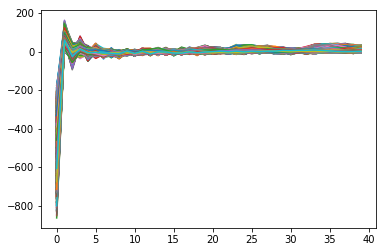

In [46]:
for item in X1:
    plt.plot(item)

# 2- Model Building

### 2.1- MEAN MFCCs REDUCED KERAS MODEL (/W using RAVDESS big data and other databases.) (4 LABEL)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asanyarray(X1), y1, test_size=0.33, random_state=42)
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [335]:
model = Sequential()
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [336]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

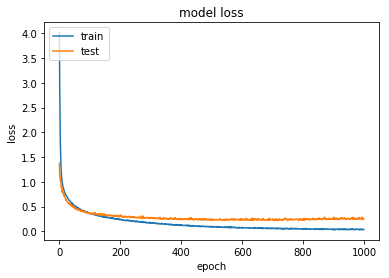

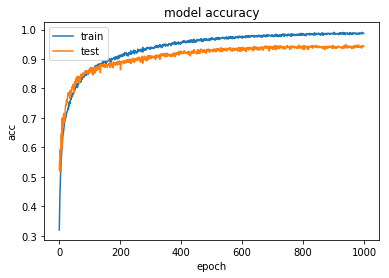

In [338]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [339]:
model_name = 'Emotion_Voice_Detection_Model_MFCC_fin.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Model_save'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Emotion_Voice_Detection_Model_MFCC_fin.h5 


In [9]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model_MFCC_fin.h5')
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1865/1865 [==============================] - 0s 126us/step
Restored model, accuracy: 94.42%


### 2.2- MEAN DB AMPLITUDE MODEL AND .T VERSION (/W using RAVDESS small data and other databases)

In [6]:
X2_db = []
for item in X2:
    S = librosa.feature.melspectrogram(y=item, sr=sr)
    k = np.mean(librosa.amplitude_to_db(S, ref=np.max).T,axis=0)
    X2_db.append(k)

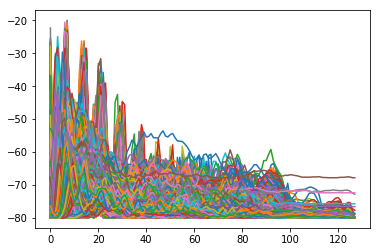

In [7]:
for item in X2_db:
    plt.plot(item)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asanyarray(X2_db), y2, test_size=0.33, random_state=42)
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [21]:
x_traincnn.shape , x_testcnn.shape

((2079, 128, 1), (1024, 128, 1))

In [22]:
model = Sequential()
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(128,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

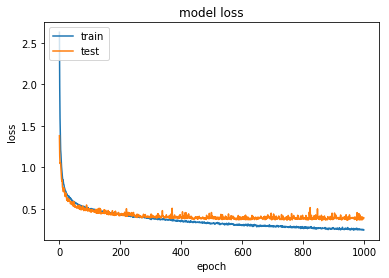

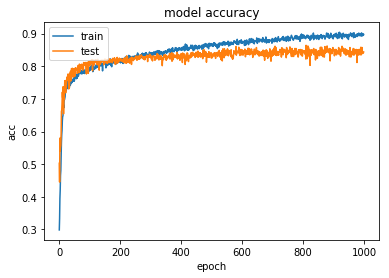

In [25]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
model_name = 'Emotion_Voice_Detection_Model_DBAmp_fin.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Emotion_Voice_Detection_Model_DBAmp_fin.h5 


In [27]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model_DBAmp_fin.h5')
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1024/1024 [==============================] - 0s 264us/step
Restored model, accuracy: 84.38%


### 2.3- WAVELET DATA EXPLORATION & MODEL BUILDING

In [8]:
import pywt
waveletted = []
for item in X2:
    a,b = pywt.dwt(item, 'db1')
    waveletted.append(a)

In [9]:
X2_new = []
a_new= []
for i in range(len(waveletted)):
    for item in waveletted[i]:
        if item > 0.001:
            a_new.append(item)
    X2_new.append(a_new)
    a_new = []

In [10]:
sample_final = []
sampled_list = []
for i in range(len(X2_new)):
    k = 0
    sums = 0
    for item in X2_new[i]:
        if len(sampled_list) == 128:
            continue
        sums = item + sums
        k = k+1
        if k == int(len(X2_new[i])/128):
            sampled_list.append(sums/k)
            k=0
            sums=0
    sample_final.append(sampled_list)
    sampled_list=[]

In [198]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asanyarray(sample_final), y2, test_size=0.33, random_state=42)
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [202]:
model = Sequential()
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(128,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [128]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

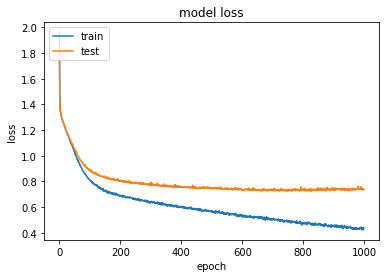

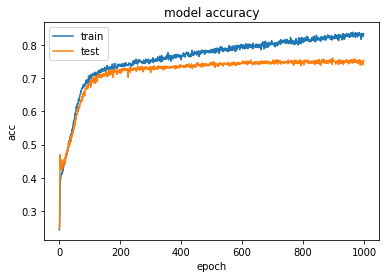

In [130]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
model_name = 'Emotion_Voice_Detection_Model_wavelet_128.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Emotion_Voice_Detection_Model_wavelet_128.h5 


In [132]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model_wavelet_128.h5')
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1024/1024 [==============================] - 0s 248us/step
Restored model, accuracy: 75.39%


# 3- Model Testing & Evaluating 

## 3.1- Input Data Transformation Pipeline

In [13]:
def soundtransformations (inputwav):
    #Output order: mfcc, meandb, wavelet.
    X, sample_rate = librosa.load(inputwav)
    if sample_rate != 22050:
        raise Exception("Sample rate must be 22050. Check your sample rate!")
    #getting mfccs    
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    #getting mean db
    S = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    dbmean = np.mean(librosa.amplitude_to_db(S, ref=np.max).T,axis=0)
    #wavelet
    a,b = pywt.dwt(X, 'db1')
    b = []
    for item in a:
        if item > 0.001:
            b.append(item)
    a = []
    k = 0
    sums = 0
    for item in b:
        if len(a) == 128:
            continue
        sums = item + sums
        k = k+1
        if k == int(len(b)/128):
            a.append(sums/k)
            k=0
            sums=0
    if len(a) != 128 or len(mfccs) != 40 or len(dbmean) != 128:
        raise Exception("Error: Check input data or soundtransformations() function.")
    o1,o2,o3 =  np.asanyarray(mfccs) , np.asanyarray(dbmean), np.asanyarray(a)
    o1,o2,o3 =  np.expand_dims(o1, axis=0), np.expand_dims(o2, axis=0), np.expand_dims(o3, axis=0)
    return np.expand_dims(o1, axis=2), np.expand_dims(o2, axis=2), np.expand_dims(o3, axis=2)

In [69]:
o1,o2,o3 = soundtransformations("/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Test_Data/6.wav")

In [43]:
m1.predict_classes(o1), m2.predict_classes(o2), m3.predict_classes(o3)

(array([3]), array([3]), array([3]))

## 3.2- Loading All Models

In [15]:
def modelloader():
    #Output order: mfcc, db, wavelet.
    mfccs_model = keras.models.load_model('Emotion_Voice_Detection_Model_MFCC_fin.h5')
    db_model = keras.models.load_model('Emotion_Voice_Detection_Model_DBAmp_fin.h5')
    wavelet_model = keras.models.load_model('Emotion_Voice_Detection_Model_wavelet_128.h5')
    return mfccs_model,db_model,wavelet_model

In [16]:
m1, m2, m3 = modelloader()

## 3.3- Predicting & Combining Results

In [108]:
#Label Meanings: 0= Neutral, 1= Happy, 2= Sad, 3= Anger

In [17]:
m1.predict_classes(o1), m2.predict_classes(o2), m3.predict_classes(o3)

(array([3]), array([3]), array([1]))